2021-06-04 ~ 2024-02-29


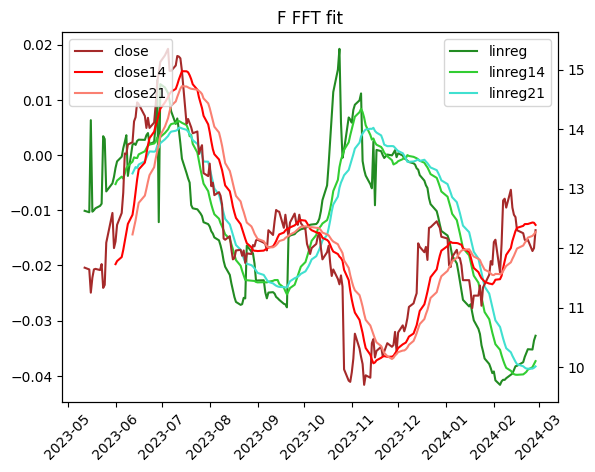

F 93% with 7 buy orders and 0 sell orders
  type   open_time  open_price  close_time  close_price  profit
0  buy  2023-06-12       13.78  2023-07-19        14.10    2.32
1  buy  2023-07-20       14.03  2023-07-21        13.93   -0.71
2  buy  2023-09-11       12.22  2023-09-18        12.34    0.98
3  buy  2023-09-27       12.39  2023-11-13         9.82  -20.74
4  buy  2023-12-06       10.69  2023-12-14        12.08   13.00
5  buy  2023-12-15       12.02  2023-12-18        11.93   -0.75
6  buy  2024-02-26       11.95  2024-02-28        12.30    2.93
2021-06-04 ~ 2024-02-29


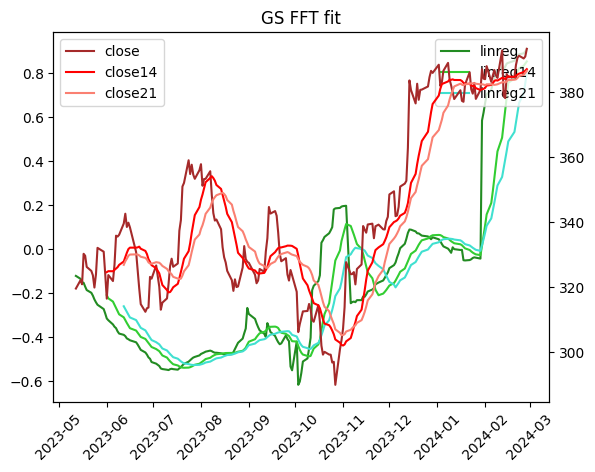

GS 106% with 4 buy orders and 0 sell orders
  type   open_time  open_price  close_time  close_price  profit
0  buy  2023-07-28  353.230011  2023-09-22   327.890015   -7.17
1  buy  2023-11-09  320.779999  2023-11-13   326.910004    1.91
2  buy  2023-12-04  349.390015  2024-01-09   383.739990    9.83
3  buy  2024-02-06  384.989990  2024-02-28   393.179993    2.13


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00009 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = list(close)[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym


def get_signal(df):
    if df["EMA1"] - df['EMA2'] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
def main_v3(day=200, test_len=200, ticker="NVDA", ma1=14, ma2=28):
    start =  datetime.now()- timedelta(days=1000+day)
    end = datetime.now() - timedelta(days=day)
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    close = shop['Close']
    linregress_array = [None] * test_len

    for i in range(test_len):
        # 1/30 => 1/29 => 1/28 => ...
        close1 = close[::-1][i:i+300]
        a = main_v2(ticker, close1, 0)
        r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
        linregress_array[i] = r
        # print(r)
    show = [i if i != 0 else 1 for i in linregress_array]
    # ma1 = 14
    # ma2 = 28
    # print(linregress_array)
    fig, ax1 = plt.subplots()
    df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
    df[f'EMA1'] = df['linreg'].rolling(ma1).mean()
    df[f'EMA2'] = df['linreg'].rolling(ma2).mean()
    df["CLMA1"] = df['close'].rolling(ma1).mean()
    df["CLMA2"] = df['close'].rolling(ma2).mean()
    df['Signal'] = df.apply(get_signal, axis=1)
    ax2 = ax1.twinx()
    ax1.plot(close.index[-test_len:], df['linreg'], 'forestgreen', label='linreg')
    ax1.plot(close.index[-test_len:], df[f'EMA1'], 'limegreen', label=f'linreg{ma1}')
    ax1.plot(close.index[-test_len:], df[f'EMA2'], 'turquoise', label=f'linreg{ma2}')
    ax2.plot(close.index[-test_len:], close[-test_len:], 'brown', label='close')
    ax2.plot(close.index[-test_len:], df['CLMA1'], 'red', label=f'close{ma1}')
    ax2.plot(close.index[-test_len:], df["CLMA2"], 'salmon', label=f'close{ma2}')
    ax1.tick_params(axis='x', rotation=45)
    plt.title(f"{ticker} FFT fit")
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.show()
    res = backtest_manual(df, ticker)
    return res
   

def backtest_manual(df, ticker):
    log_profit = 1
    order = None
    orders_buy = 0
    orders_sell = 0
    df_output = []
    df_temp_output = []
    for i in range(len(df['Signal'])):
        if (list(df['Signal'])[i] == 1 and order == None):
            if (list(df['CLMA1'])[i] > list(df["CLMA2"])[i]):
                open_price = list(df['close'])[i]
                order = "buy"
                df_temp_output.append(order)
                df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
                df_temp_output.append(open_price)
        elif (list(df['Signal'])[i] == 0 and order == "buy"):
            #  or (list(df['CLMA1'])[i] < list(df["CLMA2"])[i])
            close_price = list(df['close'])[i]
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_buy += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
        ## sell position or not
        # elif list(df['Signal'])[i] == 0 and order == None:
        #     open_price = list(df['close'])[i]
        #     order = 'sell'
        #     df_temp_output.append(order)
        #     df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        #     df_temp_output.append(open_price)
        # elif list(df['Signal'])[i] == 1 and order == 'sell':
        #     close_price = list(df['close'])[i]
        #     profit = -(close_price - open_price)/open_price
        #     log_profit *= (1+profit)
        #     order = None
        #     orders_sell += 1
        #     df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        #     df_temp_output.append(close_price)
        #     df_temp_output.append(round(profit*100, 2))
        #     df_output.append(df_temp_output)
        #     df_temp_output = []
    if order == 'buy' or order == 'sell':
        close_price = list(df['close'])[-1]
        if order == 'sell':
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_sell += 1
        elif order == 'buy':
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
        order = None
    print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
    df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
    return df_final
    # EB
take = ["OGN", "FFIN", "CE", "AMZN", "MSFT", "PANL", "SHLS", "CDNS", "ATRA", "BRBR", "EYPT", 'CABA', "VERI", 'TXT', "IBKR", "PSTX", "RPD", "MORF", "AER", "SPR", "EPC"]
takes = ["F", "GS"]
for i in takes:
    print(main_v3(day=0, test_len=200, ticker=i, ma1=14, ma2=21))

2022-05-28 ~ 2024-02-28


C:\Users\Jamie\AppData\Local\Temp\ipykernel_3960\699724445.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[i] = close[i]


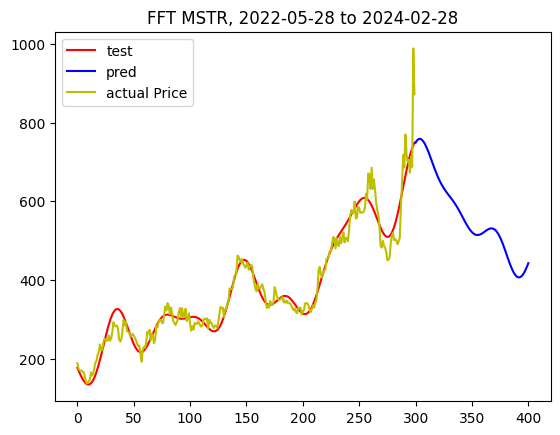

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta

def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b


def main(ticker, shop, day=0):
    start = datetime.now() - timedelta(days=441+day)
    end = datetime.now()
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300
    close = shop['Close']
    close = close[::-1]
    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)

    plt.plot(np.arange(0, len(xm), 1), xm[::-1], color ='r', label="test")
    plt.plot(np.arange(len(xm), len(xm) + len(ym), 1), ym, color = "blue", label="pred")
    plt.plot(np.arange(0, len(xm), 1), x[::-1], color='y', label='actual Price')
    plt.title(f"FFT {ticker}, {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")
    plt.legend()
    plt.show()

main("MSTR", 200, 200)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00001 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = list(close)[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym
day = 400
test_len = 200
ticker = "NVDA"
start =  datetime.now()- timedelta(days=1000+day)
end = datetime.now() - timedelta(days=day)
print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
close = shop['Close']
linregress_array = [None] * test_len

for i in range(test_len):
    # 1/30 => 1/29 => 1/28 => ...
    close1 = close[::-1][i:i+300]
    a = main_v2(ticker, close1, 0)
    r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
    linregress_array[i] = r
print(linregress_array[::-1])


2020-04-29 ~ 2023-01-24
[-1.5645110715901627, -1.5539950232060658, -1.539978238846558, -1.5231556323277478, -1.5056027030193746, -1.4220730990150854, -1.3983346985884888, -1.3646774583508359, -1.3087627771031374, -1.2382805921751745, -1.1658340277503625, -1.1427394723944473, -1.0110727075379955, -0.9216887461992234, -0.8866152587092478, -0.7176405866319029, -0.7065426665743695, -0.6648179662969772, -0.6457167875510568, -0.5854950292274249, -0.5641026670738934, -0.4926795413284231, -0.46612039377401515, -0.3828348957311991, -0.32269022038276507, -0.27192420507456205, -0.21102835977440101, -0.18093309826978593, -0.10360479167290439, -0.06423918854736901, -0.018286772348025334, 0.020672892118636654, -0.024865173799946995, 0.10534999422891184, 0.13570348186617542, 0.12565762732191882, 0.19547830705544406, 0.03668519103888729, 0.04591362626622362, 0.02542676808446026, -0.01041623944245367, -0.01008666907608634, -0.028647424294768183, -0.022562965027414363, -0.020573216877760616, -0.01855806

In [65]:
def get_signal(df):
    if df["EMA_20"] - df["EMA_60"] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
df['Signal'] = df.apply(get_signal, axis=1)
current = 0
log_profit = 1
order = None
orders_buy = 0
orders_sell = 0
df_output = []
df_temp_output = []
for i in range(len(df['Signal'])):
    if df['Signal'][i] == 1 and order == None:
        open_price = df['close'][i]
        order = "buy"
        df_temp_output.append(order)
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(open_price)
    elif df['Signal'][i] == 0 and order == "buy":
        close_price = df['close'][i]
        profit = (close_price - open_price)/open_price
        log_profit *= (1+profit)
        order = None
        orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
    elif df['Signal'][i] == 0 and order == None:
        open_price = df['close'][i]
        order = 'sell'
        df_temp_output.append(order)
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(open_price)
    elif df['Signal'][i] == 1 and order == 'sell':
        close_price = df['close'][i]
        profit = -(close_price - open_price)/open_price
        log_profit *= (1+profit)
        order = None
        orders_sell += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
if order == 'buy' or order == 'sell':
    close_price = df['close'][-1]
    if order == 'sell':
        profit = -(close_price - open_price)/open_price
        log_profit *= (1+profit)
        orders_sell += 1
    elif order == 'buy':
        profit = (close_price - open_price)/open_price
        log_profit *= (1+profit)
        orders_buy += 1
    df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
    df_temp_output.append(close_price)
    df_temp_output.append(round(profit*100, 2))
    df_output.append(df_temp_output)
    df_temp_output = []
    order = None
print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
df_final

NVDA 124% with 2 buy orders and 2 sell orders


,type,open_time,open_price,close_time,close_price,profit
0,sell,2022-04-06,244.070007,2022-07-01,145.229996,40.50
1,buy,2022-07-05,149.639999,2022-10-27,131.759995,-11.95
2,sell,2022-10-28,138.339996,2022-12-06,159.869995,-15.56
3,buy,2022-12-07,161.199997,2023-01-23,191.929993,19.06


In [20]:
df

,close,linreg,EMA_20,EMA_60,Signal
Date,,,,,
2022-12-13,274.279999,-0.202728,NaN,NaN,0
2022-12-14,274.529999,-0.201527,NaN,NaN,0
2022-12-15,271.730011,-0.199038,NaN,NaN,0
2022-12-16,266.119995,-0.194675,NaN,NaN,0
2022-12-19,265.829987,-0.192486,NaN,NaN,0
...,...,...,...,...,...
2023-09-25,269.779999,-0.228537,-0.216956,-0.212774,0
2023-09-26,267.720001,-0.230718,-0.218266,-0.213362,0
2023-09-27,263.640015,-0.234161,-0.219780,-0.214044,0
